## Dataset Characterization
### 15/09/25

In [1]:
#### Load libs
import os
from ase.db import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations
import os, json, sqlite3, re, math
from functools import reduce
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm 
from scipy.stats import pearsonr 
from collections import Counter

## Table with all properties

### Check all properties inside C2DB

In [2]:
def scan_c2db_properties_fixed():
    """
    Scans C2DB database and returns all available properties with their types and sample values,
    including a complete scan of key_value_pairs across all systems.
    
    This version correctly finds a sample value for each property from the first row 
    in which it appears, rather than relying only on the very first row of the database.
    """
    db_path = "c2db.db"
    if not os.path.exists(db_path):
        print(f"ERROR: Database file not found: {db_path}")
        return
    
    db = connect(db_path)
    all_properties = {}
    
    # Get base properties from the first row (these are consistent across all rows)
    try:
        first_row = next(db.select())
        base_attrs = [attr for attr in dir(first_row) 
                     if not attr.startswith('_') and not callable(getattr(first_row, attr))]
        
        for attr in base_attrs:
            # We will handle key_value_pairs and data specifically below
            if attr not in ['key_value_pairs', 'data']:
                all_properties[f"base.{attr}"] = {
                    "type": type(getattr(first_row, attr)).__name__,
                    "sample": str(getattr(first_row, attr))[:50]
                }
    except StopIteration:
        print("Database is empty!")
        return
        
    print("Scanning all systems for key-value pairs and data properties...")
    # Single pass to collect all unique properties from kvp and data
    for row in tqdm(db.select()):
        # Scan key_value_pairs
        kvp = getattr(row, "key_value_pairs", {})
        for k, v in kvp.items():
            prop_name = f"kvp.{k}"
            # If we see this property for the first time, grab its info
            if prop_name not in all_properties:
                all_properties[prop_name] = {
                    "type": type(v).__name__,
                    "sample": str(v)[:50]
                }

        # Scan data dictionary
        data = getattr(row, "data", {})
        if data:
            for k, v in data.items():
                prop_name = f"data.{k}"
                # If we see this property for the first time, grab its info
                if prop_name not in all_properties:
                    all_properties[prop_name] = {
                        "type": type(v).__name__,
                        "sample": str(v)[:50]
                    }

    # --- O restante do código para criar e exibir o DataFrame permanece o mesmo ---
    
    # Create DataFrame
    props_data = []
    for prop_name, info in all_properties.items():
        source, name = prop_name.split('.', 1)
        
        props_data.append({
            "Source": source,
            "Property Name": name,
            "Type": info["type"],
            "Sample Value": info["sample"]
        })
    
    df = pd.DataFrame(props_data)
    
    # Group by source and display
    print("\n=== All Properties by Source ===")
    for source in sorted(df['Source'].unique()):
        print(f"\n--- Properties from {source.upper()} ---")
        source_df = df[df['Source'] == source].sort_values('Property Name')
        with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
            print(source_df[['Property Name', 'Type', 'Sample Value']].to_string(index=False))
            
    # Save to CSV
    output_path = "c2db_properties_full_list.csv"
    df.sort_values(by=['Source', 'Property Name']).to_csv(output_path, index=False)
    print(f"\nComplete properties list saved to '{output_path}'")
    
    return df

# Execute the scan
if __name__ == "__main__":
    print("Scanning C2DB properties with the fixed method...")
    properties_df = scan_c2db_properties_fixed()

Scanning C2DB properties with the fixed method...
Scanning all systems for key-value pairs and data properties...


16905it [00:03, 5115.77it/s]


=== All Properties by Source ===

--- Properties from BASE ---
         Property Name    Type                                        Sample Value
                alphax   float                                   5.099010388010949
             alphax_el   float                                   2.242442555700771
            alphax_lat   float                                  2.8565678323101786
                alphay   float                                   5.552926465903848
             alphay_el   float                                   2.224324720609214
            alphay_lat   float                                   3.328601745294634
                alphaz   float                                 0.36851544090212635
             alphaz_el   float                                  0.3493705479321952
            alphaz_lat   float                                0.019144892969931143
        bravais_search     str                                            Centered
          bravais_type 

### Define properties by group

In [ ]:
# --- dataset setup ---
C2DB_PATH = "c2db.db"
MP2D_PATH = "2dmatpedia_final.db"

# --- Definition of Properties, Descriptions, and Categories ---
# Mapping of properties to their descriptions, categories, and possible keys in each DB
# Keys are guesses based on common conventions in materials databases.
PROPERTY_MAPPING = {
    # =================================================================
    # Category: Identification
    # =================================================================
    "Formula": {
        "description": "Chemical formula of the material (e.g., MoS2).",
        "category": "Identification",
        "c2db_keys": ["formula"],
        "mp2d_keys": ["formula_pretty", "formula_reduced_abc", "formula_anonymous"]
    },
    "Material ID": {
        "description": "Unique identifiers for the material, including internal IDs and links to external databases (ICSD, COD).",
        "category": "Identification",
        "c2db_keys": ["uid", "id", "olduid", "unique_id", "cod_id", "icsd_id", "doi"],
        "mp2d_keys": ["material_id", "uid", "relative_id", "source_id"]
    },
    "Elements": {
        "description": "List of chemical elements, number of atoms, and atomic numbers.",
        "category": "Identification",
        "c2db_keys": ["symbols", "numbers", "natoms"],
        "mp2d_keys": ["elements", "nelements", "chemsys"]
    },
    
    # =================================================================
    # Category: Structural
    # =================================================================
    "Space Group": {
        "description": "Information about the crystal's symmetry space group (number, symbol, layer group).",
        "category": "Structural",
        "c2db_keys": ["international", "lgnum", "layergroup", "bravais_type", "bravais_search"],
        "mp2d_keys": ["sg_number", "sg_symbol", "sg_crystal_system", "sg_point_group"]
    },
    "Thickness": {
        "description": "Effective thickness of the 2D layer in Ångstroms.",
        "category": "Structural",
        "c2db_keys": ["thickness"],
        "mp2d_keys": []
    },
    "Has Inversion Symmetry": {
        "description": "Indicates whether the crystal structure possesses inversion symmetry.",
        "category": "Structural",
        "c2db_keys": ["has_inversion_symmetry"],
        "mp2d_keys": [] # Can be inferred from space group, but no direct key in example
    },

    # =================================================================
    # Category: Electronic
    # =================================================================
    "Band Gap": {
        "description": "Energy band gap in eV. Suffixes denote the level of theory (e.g., _hse, _gw) or if it's direct (_dir).",
        "category": "Electronic",
        "c2db_keys": ["gap", "gap_hse", "gap_gw", "gap_u", "gap_dir", "gap_dir_hse", "gap_dir_gw", "gap_dir_nosoc", "gap_dir_u"],
        "mp2d_keys": ["bandgap"]
    },
    "Half Metal Gap": {
        "description": "Spin-channel gap for half-metallic materials in eV.",
        "category": "Electronic",
        "c2db_keys": ["halfmetal_gap", "halfmetal_gap_hse", "halfmetal_gap_dir", "halfmetal_gap_dir_hse"],
        "mp2d_keys": []
    },
    "Band Edges (CBM/VBM)": {
        "description": "Energy of the Conduction Band Minimum (CBM) and Valence Band Maximum (VBM) in eV.",
        "category": "Electronic",
        "c2db_keys": ["cbm", "cbm_hse", "cbm_gw", "cbm_u", "vbm", "vbm_hse", "vbm_gw", "vbm_u"],
        "mp2d_keys": [] # Not present in the provided example
    },
    "Effective Mass": {
        "description": "Effective mass of charge carriers (electrons at CBM and holes at VBM), in units of electron mass (m_e).",
        "category": "Electronic",
        "c2db_keys": ["emass_cbm", "emass_vbm"],
        "mp2d_keys": []
    },
    "Fermi Level": {
        "description": "The Fermi level (or valence band maximum for semiconductors) in eV.",
        "category": "Electronic",
        "c2db_keys": ["efermi", "efermi_hse", "efermi_gw", "efermi_u"],
        "mp2d_keys": []
    },
    
    # =================================================================
    # Category: Stability (Thermodynamic & Vibrational)
    # =================================================================
    "Total Energy": {
        "description": "Total energy per atom in eV/atom.",
        "category": "Thermodynamic Stability",
        "c2db_keys": ["energy"],
        "mp2d_keys": ["energy_per_atom", "energy_vdw_per_atom"]
    },
    "Energy Above Hull": {
        "description": "Energy above the convex hull in eV/atom. A value near zero indicates thermodynamic stability.",
        "category": "Thermodynamic Stability",
        "c2db_keys": ["ehull"],
        "mp2d_keys": ["decomposition_energy"] # Similar concept
    },
    "Formation Energy": {
        "description": "Energy of formation per atom in eV/atom.",
        "category": "Thermodynamic Stability",
        "c2db_keys": ["hform"],
        "mp2d_keys": []
    },
    "Exfoliation Energy": {
        "description": "Energy required to exfoliate the 2D layer from its parent bulk crystal, in eV/atom.",
        "category": "Thermodynamic Stability",
        "c2db_keys": [], # Not explicitly present in C2DB list
        "mp2d_keys": ["exfoliation_energy_per_atom"]
    },
    "Dynamical Stability": {
        "description": "Indicates if the material is dynamically stable (no imaginary vibrational modes).",
        "category": "Vibrational",
        "c2db_keys": ["dyn_stab", "minhessianeig"],
        "mp2d_keys": []
    },
    
    # =================================================================
    # Category: Magnetic
    # =================================================================
    "Total Magnetization": {
        "description": "Total magnetic moment of the unit cell in Bohr magnetons (μB). Suffix '_u' indicates a DFT+U calculation.",
        "category": "Magnetic",
        "c2db_keys": ["magmom", "magmom_u", "spin", "spin_u"],
        "mp2d_keys": ["total_magnetization"]
    },
    "Is Magnetic": {
        "description": "Boolean flag indicating whether the material is magnetic.",
        "category": "Magnetic",
        "c2db_keys": ["is_magnetic", "is_magnetic_u"],
        "mp2d_keys": [] # Inferred from total_magnetization != 0
    },
    "Magnetic Coupling": {
        "description": "Magnetic exchange coupling constants (J) and single-ion anisotropy (A) in meV.",
        "category": "Magnetic",
        "c2db_keys": ["J", "J_u", "A", "A_u"],
        "mp2d_keys": []
    },

    # =================================================================
    # Category: Dielectric & Optical Properties
    # =================================================================
    "Polarizability Tensor": {
        "description": "Components of the polarizability tensor (α_xx, α_yy, α_zz), with electronic (_el) and lattice (_lat) contributions.",
        "category": "Dielectric",
        "c2db_keys": ["alphax", "alphay", "alphaz", "alphax_el", "alphay_el", "alphaz_el", "alphax_lat", "alphay_lat", "alphaz_lat"],
        "mp2d_keys": []
    },
    "Plasma Frequency": {
        "description": "Frequency of collective electron oscillations (plasmons) in eV, related to optical properties.",
        "category": "Optical"
        "",
        "c2db_keys": ["plasmafrequency_x", "plasmafrequency_y"],
        "mp2d_keys": []
    },

    # =================================================================
    # Category: Other Properties
    # =================================================================
    "Spontaneous Polarization": {
        "description": "Spontaneous electric polarization in ferroelectric materials.",
        "category": "Ferroelectric",
        "c2db_keys": ["P_spontaneous_norm", "is_ferroelectric", "dipz"],
        "mp2d_keys": []
    },
    "Topological Class": {
        "description": "Topological classification of the material (e.g., Trivial, Topological Insulator).",
        "category": "Topological",
        "c2db_keys": ["topology"],
        "mp2d_keys": []
    }
}

### Correlation analysis

In [ ]:
# --- Property Mapping (Focusing on C2DB keys) ---
PROPERTY_MAPPING = {
    "Band Gap": {
        "keys": ["gap", "gap_hse", "gap_gw", "gap_u", "gap_dir", "gap_dir_hse", "gap_dir_gw", "gap_dir_nosoc", "gap_dir_u"]
    },
    "Band Edges (CBM/VBM)": {
        "keys": ["cbm", "cbm_hse", "cbm_gw", "cbm_u", "vbm", "vbm_hse", "vbm_gw", "vbm_u"]
    },
    "Fermi Level": {
        "keys": ["efermi", "efermi_hse", "efermi_gw", "efermi_u"]
    },
    "Is Magnetic": {
        "keys": ["is_magnetic", "is_magnetic_u"]
    },
    "Half Metal Gap": {
        "keys": ["halfmetal_gap", "halfmetal_gap_hse", "halfmetal_gap_dir", "halfmetal_gap_dir_hse"]
    },
    "Plasma Frequency": {
        "keys": ["plasmafrequency_x", "plasmafrequency_y"]
    },
    "Polarizability Tensor (alpha)": {
        "keys": ["alphax", "alphay", "alphaz", "alphax_el", "alphay_el", "alphaz_el", "alphax_lat", "alphay_lat", "alphaz_lat"]
    },
    # MODIFIED: Added the DFT+U magnetic anisotropy properties
    "Magnetic Anisotropy (dE)": {
        "keys": ["dE_zy", "dE_zx", "dE_zy_u", "dE_zx_u"]
    }
}

# --- Helper Functions ---
def is_scalar(x):
    """Checks if a value is a scalar."""
    return not isinstance(x, (list, tuple, dict, np.ndarray))

def load_c2db_dataframe(db_path: str, all_keys: set):
    """
    Reads the C2DB database and converts it to a pandas DataFrame.
    """
    if not os.path.exists(db_path):
        print(f"ERROR: Database file not found: {db_path}")
        return pd.DataFrame()

    db = connect(db_path)
    records = []
    
    print(f"Loading data from {db_path}...")
    for row in tqdm(db.select(), total=len(db)):
        record = {}
        for key, value in row.key_value_pairs.items():
            if key in all_keys and is_scalar(value):
                record[key] = value
        records.append(record)
        
    return pd.DataFrame(records)

# --- Main Logic ---
if __name__ == "__main__":
    output_dir = "c2db_correlation_heatmaps"
    os.makedirs(output_dir, exist_ok=True)
    
    all_keys_to_load = {key for prop in PROPERTY_MAPPING.values() for key in prop["keys"]}

    df_c2db = load_c2db_dataframe("c2db.db", all_keys_to_load)

    if df_c2db.empty:
        print("Could not load data from C2DB. No plots will be generated.")
    else:
        for description, details in PROPERTY_MAPPING.items():
            prop_keys = details["keys"]
            available_keys = [key for key in prop_keys if key in df_c2db.columns]
            
            if len(available_keys) < 2:
                continue

            print(f"\nGenerating heatmap for: '{description}'...")
            
            plot_df = df_c2db[available_keys].copy()
            
            for col in plot_df.columns:
                plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')

            plot_df.dropna(how='all', inplace=True)
            plot_df.dropna(axis=1, how='all', inplace=True)

            if len(plot_df.columns) < 2 or plot_df.shape[0] < 2:
                print(f" -> Not enough data to create a correlation plot for '{description}'.")
                continue

            # --- Plotting Logic ---
            corr_matrix = plot_df.corr()

            # MODIFIED: Fill NaN values with 0 to ensure all cells have a number
            #corr_matrix.fillna(0, inplace=True)

            plt.figure(figsize=(12, 10))
            sns.heatmap(
                corr_matrix, 
                annot=True,
                cmap='coolwarm',
                fmt=".2f",
                linewidths=.5,
                vmin=-1, vmax=1
            )
            plt.title(f"Correlation Heatmap for: {description}", fontsize=16)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            
            safe_filename = re.sub(r'[^a-zA-Z0-9_-]', '', description.replace(' ', '_'))
            output_path = os.path.join(output_dir, f"c2db_corr_{safe_filename}.png")
            
            plt.savefig(output_path, bbox_inches='tight')
            plt.close()
            print(f" -> Saved heatmap to '{output_path}'")

Loading data from c2db.db...


100%|██████████| 16905/16905 [00:02<00:00, 7125.82it/s]



Generating heatmap for: 'Band Gap'...


### Create table with all properties

In [8]:
# List to store the detailed table data
detailed_table_data = []

# Iterate over the mapping dictionary
for prop_name, prop_details in PROPERTY_MAPPING.items():
    # Extract the category and definition
    category = prop_details["category"]
    description = prop_details["description"]
    
    # Process keys from C2DB
    for key in prop_details["c2db_keys"]:
        detailed_table_data.append({
            "Property": key,
            "Class": category,
            "Definition": description
        })
        
    # Process keys from 2DMatpedia, adding the '_2dmp' suffix
    for key in prop_details["mp2d_keys"]:
        detailed_table_data.append({
            "Property": f"{key}_2dmp",
            "Class": category,
            "Definition": description
        })

# Create the final DataFrame
df_definitions_detailed = pd.DataFrame(detailed_table_data)

# Remove potential duplicate rows that might arise if a key is processed identically
df_definitions_detailed.drop_duplicates(inplace=True)

# Sort the table by Property name for consistency
df_definitions_detailed.sort_values(by="Property", inplace=True)


# Set display options for better console output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Display the detailed table
print("=== Detailed Property Definition Table (with Suffix for 2DMatpedia) ===")
print(df_definitions_detailed.to_string(index=False))

# Save the new table to a CSV file
output_filename_detailed = "property_definitions_detailed_suffixed.csv"
df_definitions_detailed.to_csv(output_filename_detailed, index=False)

print(f"\nDetailed table successfully saved to file: '{output_filename_detailed}'")

=== Detailed Property Definition Table (with Suffix for 2DMatpedia) ===
                        Property                        Class                                                                                                          Definition
                               A          Magnetic Properties                                      Magnetic exchange coupling constants (J) and single-ion anisotropy (A) in meV.
                             A_u          Magnetic Properties                                      Magnetic exchange coupling constants (J) and single-ion anisotropy (A) in meV.
                               J          Magnetic Properties                                      Magnetic exchange coupling constants (J) and single-ion anisotropy (A) in meV.
                             J_u          Magnetic Properties                                      Magnetic exchange coupling constants (J) and single-ion anisotropy (A) in meV.
              P_spontaneous_norm     F

## Structure Characterization

### Number of structures by dataset

In [24]:
# --- File Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]

def characterize_database(db_path: str):
    """
    Analyzes an ASE database to count total and unique systems.
    A unique system (prototype) is defined by its formula and symmetry group.
    """
    if not os.path.exists(db_path):
        print(f"--- Database: {db_path} ---\nFile not found.\n")
        return

    print(f"--- Database: {db_path} ---")
    
    db = connect(db_path)
    total_systems = len(db)
    
    unique_prototypes = set()

    # --- Identify symmetry columns (once per DB) ---
    try:
        row_sample = next(db.select(limit=1))
        keys = list(row_sample.key_value_pairs.keys()) + list(getattr(row_sample, 'data', {}).keys())
    except StopIteration:
        print("Total systems: 0")
        print("Unique systems (formula + symmetry): 0\n")
        return # Empty database

    num_col_candidates = ["sg_number", "spacegroup_number", "number", "lgnum", "layergroup_number"]
    sym_col_candidates = ["sg_symbol", "spacegroup_symbol", "international", "layergroup"]
    
    num_col = next((c for c in num_col_candidates if c in keys), None)
    sym_col = next((c for c in sym_col_candidates if c in keys), None)

    # --- Iterate through all entries to find unique prototypes ---
    for row in db.select():
        # Check for presence of atomic coordination (geometry)
        try:
            atoms = row.toatoms()
            # A valid cell should have a non-zero volume (determinant)
            if abs(np.linalg.det(atoms.cell)) < 1e-6:
                continue
        except Exception:
            # Skip rows where geometry cannot be constructed
            continue

        formula = row.get("formula_norm", row.formula)
        prototype = None
        
        # Priority 1: Use symmetry number if available and valid
        if num_col and row.get(num_col) is not None:
            try:
                sym_num = int(row.get(num_col))
                prototype = (formula, "number", str(sym_num))
            except (ValueError, TypeError):
                pass
        
        # Priority 2: Use symmetry symbol if no number is available
        elif sym_col and row.get(sym_col) is not None:
            try:
                sym_symb = re.sub(r"\\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if sym_symb:
                    prototype = (formula, "symbol", sym_symb)
            except (ValueError, TypeError):
                pass
        
        if prototype:
            unique_prototypes.add(prototype)

    unique_systems_count = len(unique_prototypes)
    
    print(f"Total systems: {total_systems}")
    print(f"Unique systems (formula + symmetry): {unique_systems_count}\n")


if __name__ == "__main__":
    for path in DB_PATHS:
        characterize_database(path)

--- Database: c2db.db ---
Total systems: 16905
Unique systems (formula + symmetry): 16504

--- Database: 2dmatpedia_final.db ---
Total systems: 6351
Unique systems (formula + symmetry): 6159



### Structure Volume


Processing database: c2db.db


Calculating volumes: 100%|██████████| 16504/16504 [00:00<00:00, 18635.70it/s]


Found 16454 unique structures with valid volume > 0.

Processing database: 2dmatpedia_final.db


Calculating volumes: 100%|██████████| 6159/6159 [00:00<00:00, 31202.36it/s]


Found 5975 unique structures with valid volume > 0.

Comparison plot saved as 'volume_distribution_comparison.png'


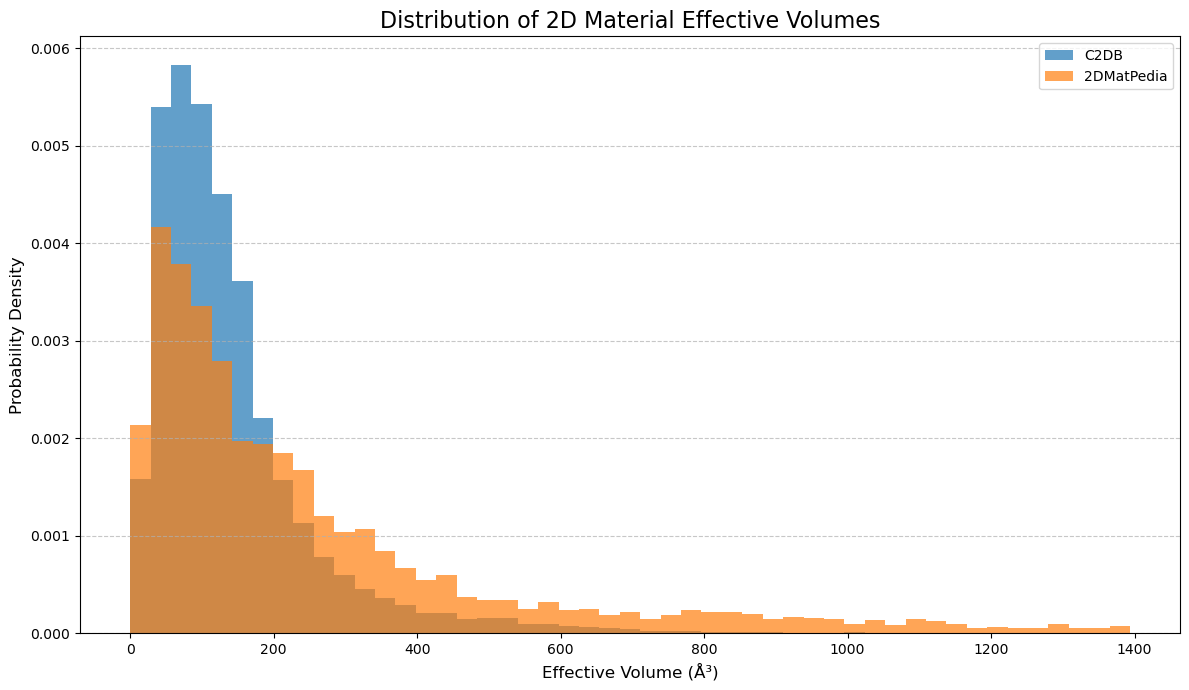

In [25]:
# --- File Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]

def get_unique_prototypes_map(db_path: str):
    """
    Reads an ASE database and returns a dictionary mapping each unique prototype
    (formula, sym_type, sym_val) to its first corresponding row object.
    """
    if not os.path.exists(db_path):
        return {}

    proto_to_row_map = {}
    db = connect(db_path)
    
    # Identify symmetry columns
    try:
        row_sample = next(db.select(limit=1))
        keys = list(row_sample.key_value_pairs.keys()) + list(getattr(row_sample, 'data', {}).keys())
    except StopIteration:
        return {}

    num_col = next((c for c in ["sg_number", "number", "lgnum"] if c in keys), None)
    sym_col = next((c for c in ["international", "layergroup"] if c in keys), None)

    for row in db.select():
        formula = row.get("formula_norm", row.formula)
        prototype = None
        
        if num_col and row.get(num_col) is not None:
            try:
                prototype = (formula, "number", str(int(row.get(num_col))))
            except (ValueError, TypeError): pass
        elif sym_col and row.get(sym_col) is not None:
            try:
                sym_symb = re.sub(r"\\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if sym_symb:
                    prototype = (formula, "symbol", sym_symb)
            except (ValueError, TypeError): pass

        if prototype and prototype not in proto_to_row_map:
            proto_to_row_map[prototype] = row
            
    return proto_to_row_map

def calculate_volumes_for_db(db_path: str):
    """
    Calculates the effective volume for all unique structures in a database.
    Volume = in-plane area * atomic slab thickness.
    """
    print(f"\nProcessing database: {db_path}")
    prototypes_map = get_unique_prototypes_map(db_path)
    volumes = []

    if not prototypes_map:
        print("No unique prototypes found.")
        return []

    for proto, row in tqdm(prototypes_map.items(), desc="Calculating volumes"):
        try:
            atoms = row.toatoms()
            cell = atoms.get_cell()
            positions = atoms.get_positions() # Cartesian coordinates

            # 1. Calculate in-plane area from the cross product of the first two lattice vectors
            area = np.linalg.norm(np.cross(cell[0], cell[1]))
            
            # 2. Calculate thickness from the z-coordinates of the atoms
            z_coords = positions[:, 2]
            thickness = np.max(z_coords) - np.min(z_coords)
            
            # 3. Calculate effective volume
            volume = area * thickness

            # 4. Validation: exclude zero or negative volumes
            if volume > 0:
                volumes.append(volume)

        except Exception:
            # Skip if any error occurs during geometry processing
            continue
            
    print(f"Found {len(volumes)} unique structures with valid volume > 0.")
    return volumes

# --- Main Execution Logic ---
if __name__ == "__main__":
    db_volumes = {}
    db_labels = {
        "c2db.db": "C2DB",
        "2dmatpedia_final.db": "2DMatPedia"
    }

    for path in DB_PATHS:
        if os.path.exists(path):
            volumes = calculate_volumes_for_db(path)
            db_volumes[db_labels[path]] = volumes
        else:
            print(f"\nDatabase not found: {path}")

    # --- Plotting the Distributions ---
    if len(db_volumes) > 0:
        plt.figure(figsize=(12, 7))
        
        # Determine a sensible range for the histogram bins
        all_volumes = [vol for vols in db_volumes.values() for vol in vols]
        if all_volumes:
            # Use percentile to avoid extreme outliers stretching the plot
            max_range = np.percentile(all_volumes, 99) 
            bins = np.linspace(0, max_range, 50)

            for label, volumes in db_volumes.items():
                plt.hist(volumes, bins=bins, alpha=0.7, label=label, density=True)

            plt.title('Distribution of 2D Material Effective Volumes', fontsize=16)
            plt.xlabel('Effective Volume (Å³)', fontsize=12)
            plt.ylabel('Probability Density', fontsize=12)
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            
            output_filename = 'volume_distribution_comparison.png'
            plt.savefig(output_filename)
            print(f"\nComparison plot saved as '{output_filename}'")
        else:
            print("\nNo valid volumes found to plot.")

### Verify if we have invalid interatomic distances

In [6]:

# --- Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]
MIN_DISTANCE_THRESHOLD = 0.5  # Angstroms (Å)

def validate_database_distances(db_path: str, min_dist_threshold: float):
    """
    Analyzes an ASE database to count how many structures are valid
    based on the minimum interatomic distance criterion.
    """
    if not os.path.exists(db_path):
        print(f"--- Database: {db_path} ---\nFile not found.\n")
        return

    print(f"--- Validating structures in: {db_path} ---")
    
    db = connect(db_path)
    total_structures = 0
    valid_structures = 0

    # Track overall min and max distances across the entire dataset
    overall_min_dist = np.inf
    overall_max_dist = 0.0

    # Using tqdm for a progress bar as this can be a slow process
    for row in tqdm(db.select(), total=len(db)):
        total_structures += 1
        
        try:
            atoms = row.toatoms()
            
            # Skip structures with no atoms
            if len(atoms) < 2:
                valid_structures += 1 # A single-atom structure is valid by this criterion
                continue

            # --- Key Calculation Step ---
            # Get all distances, using mic=True to account for
            # periodic boundary conditions (Minimum Image Convention).
            dist_matrix = atoms.get_all_distances(mic=True)
            
            max_found_dist = np.max(dist_matrix)
            # The diagonal of the matrix is the distance of an atom to itself (0).
            # We need to find the minimum non-zero distance.
            # A simple way is to fill the diagonal with infinity before finding the minimum.
            np.fill_diagonal(dist_matrix, np.inf)
            
            min_found_dist = np.min(dist_matrix)

            # Update the overall min and max distances
            if min_found_dist < overall_min_dist:
                overall_min_dist = min_found_dist
            if max_found_dist > overall_max_dist:
                overall_max_dist = max_found_dist

            # --- Validation Check ---
            if min_found_dist >= min_dist_threshold:
                valid_structures += 1

        except Exception:
            # Skip if any error occurs during geometry processing
            continue

    print(f"Overall minimum distance found in structures: {overall_min_dist:.2f} Å")
    print(f"Overall maximum distance found in structures: {overall_max_dist:.2f} Å")
            
    # Print the summary for this database
    if total_structures > 0:
        percentage = (valid_structures / total_structures) * 100
        print(f"Total structures checked: {total_structures}")
        print(f"Valid structures found (min distance >= {min_dist_threshold} Å): {valid_structures}")
        print(f"Percentage of valid structures: {percentage:.2f}%\n")
    else:
        print("No structures found in the database.\n")

if __name__ == "__main__":
    for path in DB_PATHS:
        validate_database_distances(path, MIN_DISTANCE_THRESHOLD)

--- Validating structures in: c2db.db ---


100%|██████████| 16905/16905 [00:06<00:00, 2516.79it/s]


Overall minimum distance found in structures: 0.80 Å
Overall maximum distance found in structures: 19.79 Å
Total structures checked: 16905
Valid structures found (min distance >= 0.5 Å): 16905
Percentage of valid structures: 100.00%

--- Validating structures in: 2dmatpedia_final.db ---


100%|██████████| 6351/6351 [00:03<00:00, 1911.06it/s]

Overall minimum distance found in structures: 0.96 Å
Overall maximum distance found in structures: 36.72 Å
Total structures checked: 6351
Valid structures found (min distance >= 0.5 Å): 6351
Percentage of valid structures: 100.00%



### Radial Distribution Function (RDF) analysis


Processing database: c2db.db


Calculating distances in c2db.db: 16905it [00:07, 2381.47it/s]



Processing database: 2dmatpedia_final.db


Calculating distances in 2dmatpedia_final.db: 6351it [00:03, 1839.24it/s]



RDF comparison plot saved as 'rdf_comparison.png'


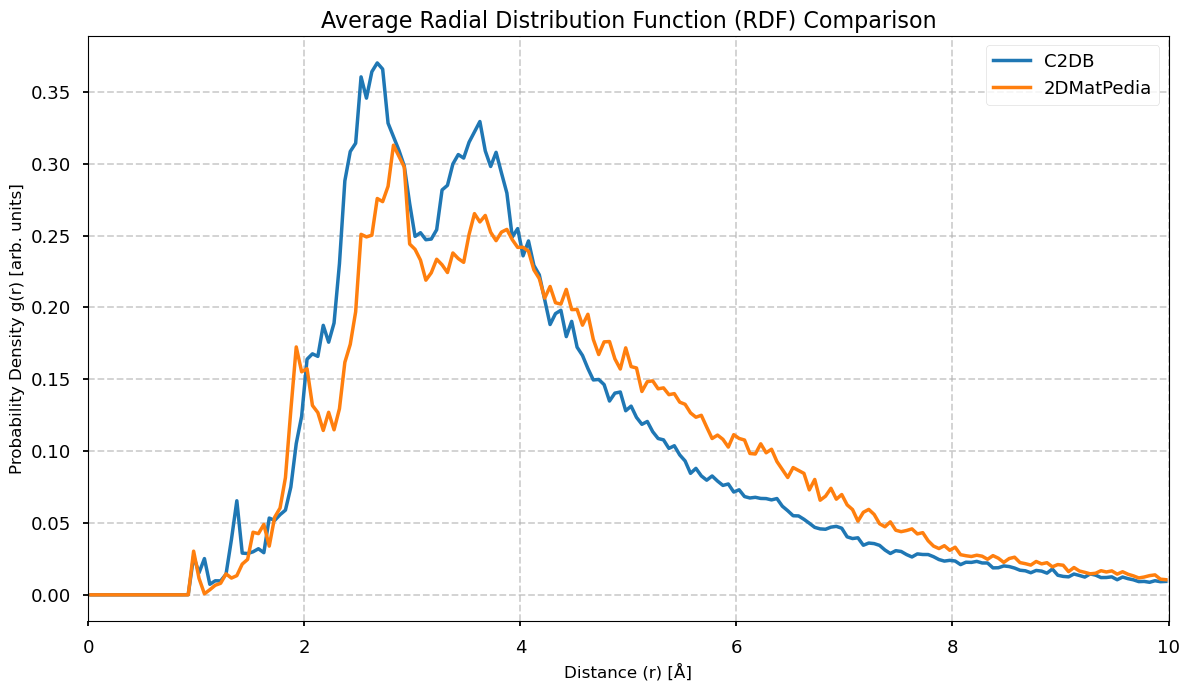

In [7]:
OUTPUT_FILENAME = "rdf_comparison.png"

# We will analyze distances up to this value (in Angstroms)
MAX_RDF_DISTANCE = 10.0 
# Number of bins for the histogram that represents the RDF
RDF_BINS = 200

def get_all_interatomic_distances(db_path: str, max_dist: float):
    """
    Reads an ASE database and collects all interatomic distances up to max_dist
    from all valid structures.
    """
    if not os.path.exists(db_path):
        print(f"Database not found: {db_path}")
        return None

    print(f"\nProcessing database: {db_path}")
    db = connect(db_path)
    
    all_distances = []

    for row in tqdm(db.select(), desc=f"Calculating distances in {os.path.basename(db_path)}"):
        try:
            atoms = row.toatoms()
            if len(atoms) < 2:
                continue

            # Get distance matrix using Minimum Image Convention
            dist_matrix = atoms.get_all_distances(mic=True)
            
            # We only need the upper triangle of the matrix to avoid double counting
            # and k=1 to exclude the diagonal (self-distances)
            distances_in_structure = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
            
            # Filter for distances within our range of interest
            relevant_distances = distances_in_structure[distances_in_structure < max_dist]
            
            all_distances.extend(relevant_distances)
        except Exception:
            continue
            
    return np.array(all_distances)

# --- Main Execution Logic ---
if __name__ == "__main__":
    db_distances = {}
    db_labels = {
        "c2db.db": "C2DB",
        "2dmatpedia_final.db": "2DMatPedia"
    }

    # --- Gather data from both databases ---
    for path in DB_PATHS:
        distances = get_all_interatomic_distances(path, MAX_RDF_DISTANCE)
        if distances is not None and len(distances) > 0:
            label = db_labels.get(path, path)
            db_distances[label] = distances

    # --- Plotting the RDFs ---
    if db_distances:
        plt.style.use('seaborn-v0_8-talk')
        plt.figure(figsize=(12, 7))

        for label, distances in db_distances.items():
            # Calculate the histogram, which is our g(r)
            counts, bin_edges = np.histogram(
                distances, 
                bins=RDF_BINS, 
                range=(0, MAX_RDF_DISTANCE), 
                density=True # Normalize to get a probability density
            )
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # A true g(r) is normalized by rho (average density), but for visual comparison
            # of peak positions, the probability density is sufficient and effective.
            plt.plot(bin_centers, counts, label=label, lw=2.5)

        plt.title('Average Radial Distribution Function (RDF) Comparison', fontsize=16)
        plt.xlabel('Distance (r) [Å]', fontsize=12)
        plt.ylabel('Probability Density g(r) [arb. units]', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(0, MAX_RDF_DISTANCE)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_FILENAME)
        print(f"\nRDF comparison plot saved as '{OUTPUT_FILENAME}'")

### Verify the natoms distribution


Processing database: c2db.db


Counting atoms in c2db.db: 16905it [00:03, 5000.49it/s]



Processing database: 2dmatpedia_final.db


Counting atoms in 2dmatpedia_final.db: 6351it [00:01, 6266.23it/s]



--- Summary Statistics ---

Dataset: C2DB
  Total structures analyzed: 16905
  Minimum number of atoms: 1
  Maximum number of atoms: 51
  Average number of atoms: 8.75

Dataset: 2DMatPedia
  Total structures analyzed: 6351
  Minimum number of atoms: 1
  Maximum number of atoms: 40
  Average number of atoms: 10.44

Comparison plot saved as 'atom_count_distribution_comparison.png'


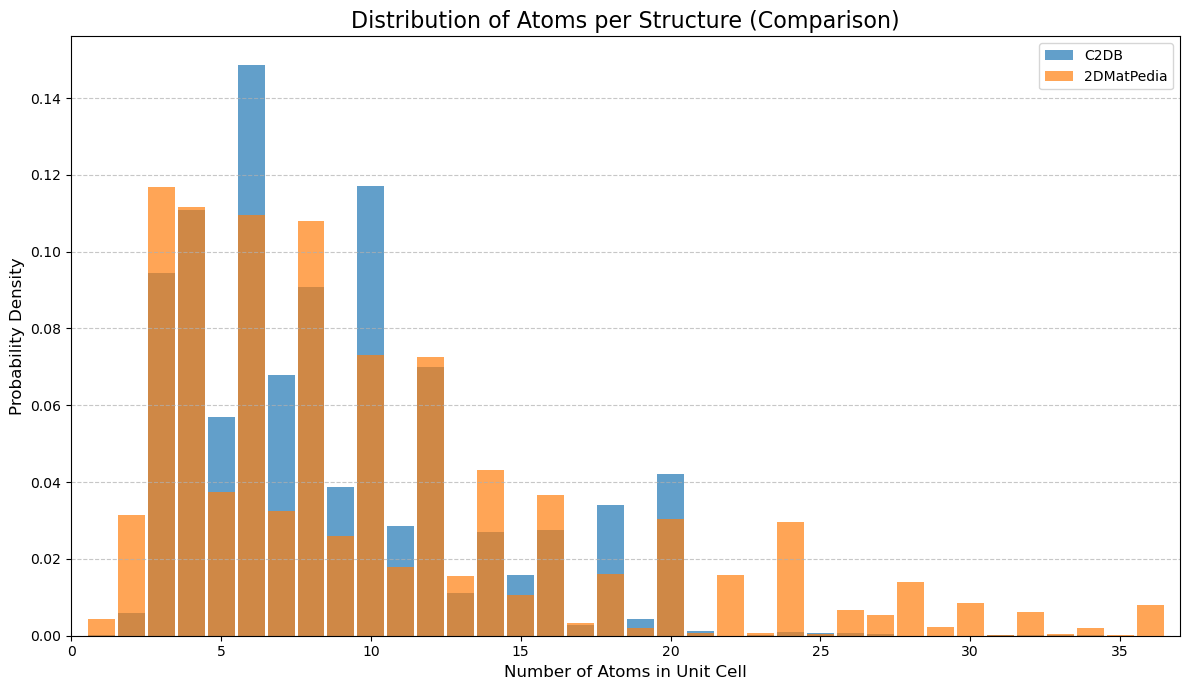

In [11]:
# --- Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]
OUTPUT_FILENAME = "atom_count_distribution_comparison.png"

def get_atom_counts_from_db(db_path: str):
    """
    Reads an ASE database and returns a list with the number of atoms
    for each structure.
    """
    if not os.path.exists(db_path):
        print(f"Database not found: {db_path}")
        return None

    print(f"\nProcessing database: {db_path}")
    db = connect(db_path)
    atom_counts = []

    # Iterate through all entries and get the atom count for each
    for row in tqdm(db.select(), desc=f"Counting atoms in {os.path.basename(db_path)}"):
        # 'natoms' is a direct attribute of the row, which is efficient
        atom_counts.append(row.natoms)
            
    return atom_counts

# --- Main Execution Logic ---
if __name__ == "__main__":
    db_atom_counts = {}
    db_labels = {
        "c2db.db": "C2DB",
        "2dmatpedia_final.db": "2DMatPedia"
    }

    # --- Gather data from both databases ---
    for path in DB_PATHS:
        counts = get_atom_counts_from_db(path)
        if counts:
            label = db_labels.get(path, path)
            db_atom_counts[label] = counts

    # --- Print Summary Statistics for each dataset ---
    if db_atom_counts:
        print("\n--- Summary Statistics ---")
        for label, counts in db_atom_counts.items():
            print(f"\nDataset: {label}")
            print(f"  Total structures analyzed: {len(counts)}")
            print(f"  Minimum number of atoms: {np.min(counts)}")
            print(f"  Maximum number of atoms: {np.max(counts)}")
            print(f"  Average number of atoms: {np.mean(counts):.2f}")

        # --- Plotting the Comparative Distribution ---
        plt.figure(figsize=(12, 7))
        
        # Determine a shared range for the histogram bins
        all_counts = [count for counts in db_atom_counts.values() for count in counts]
        if all_counts:
            max_range = np.percentile(all_counts, 99.5) # Use percentile to avoid outliers
            bins = np.arange(0, max_range + 2) - 0.5

            for label, counts in db_atom_counts.items():
                plt.hist(counts, bins=bins, alpha=0.7, label=label, density=True, rwidth=0.9)

            plt.title('Distribution of Atoms per Structure (Comparison)', fontsize=16)
            plt.xlabel('Number of Atoms in Unit Cell', fontsize=12)
            plt.ylabel('Probability Density', fontsize=12)
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xlim(0, max_range + 1)
            
            plt.tight_layout()
            plt.savefig(OUTPUT_FILENAME)
            print(f"\nComparison plot saved as '{OUTPUT_FILENAME}'")
        else:
            print("\nNo atom counts found to plot.")

### Verify the number of chemical species distribution


Processing database: c2db.db


Counting species in c2db.db: 16905it [00:05, 2926.54it/s]



Processing database: 2dmatpedia_final.db


Counting species in 2dmatpedia_final.db: 6351it [00:01, 4638.82it/s]



--- Summary of Chemical Complexity ---

Dataset: C2DB (Total: 16905 structures)
  - Unary (1 species): 33 structures (0.20%)
  - Binary (2 species): 4173 structures (24.69%)
  - Ternary (3 species): 6922 structures (40.95%)
  - 4-nary (4 species): 4129 structures (24.42%)
  - 5-nary (5 species): 1385 structures (8.19%)
  - 6-nary (6 species): 204 structures (1.21%)
  - 7-nary (7 species): 44 structures (0.26%)
  - 8-nary (8 species): 14 structures (0.08%)
  - 9-nary (9 species): 1 structures (0.01%)

Dataset: 2DMatPedia (Total: 6351 structures)
  - Unary (1 species): 92 structures (1.45%)
  - Binary (2 species): 4107 structures (64.67%)
  - Ternary (3 species): 1603 structures (25.24%)
  - 4-nary (4 species): 549 structures (8.64%)

Comparison plot saved as 'species_count_distribution_comparison.png'


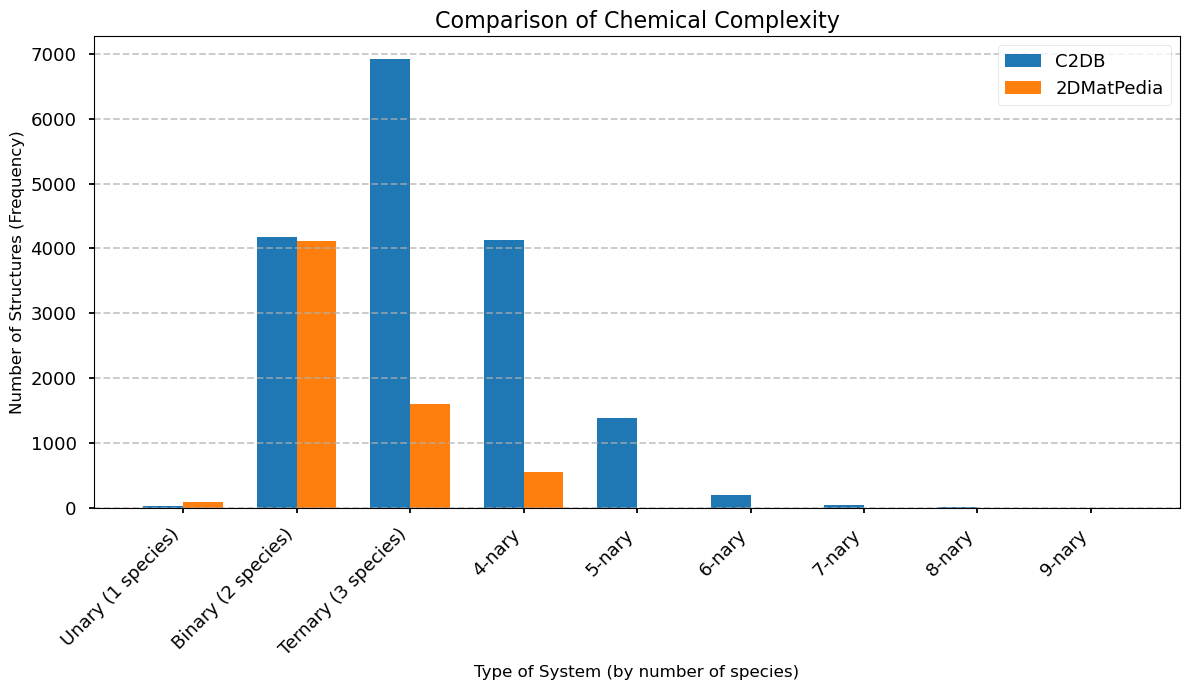

In [15]:
# --- Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]
OUTPUT_FILENAME = "species_count_distribution_comparison.png"

def get_species_counts_from_db(db_path: str):
    """
    Reads an ASE database and returns a list with the number of unique
    chemical species for each structure.
    """
    if not os.path.exists(db_path):
        print(f"Database not found: {db_path}")
        return None

    print(f"\nProcessing database: {db_path}")
    db = connect(db_path)
    species_counts = []

    for row in tqdm(db.select(), desc=f"Counting species in {os.path.basename(db_path)}"):
        try:
            atoms = row.toatoms()
            symbols = atoms.get_chemical_symbols()
            num_species = len(set(symbols))
            species_counts.append(num_species)
        except Exception:
            continue
            
    return species_counts

# --- Main Execution Logic ---
if __name__ == "__main__":
    db_species_counts = {}
    db_labels = {
        "c2db.db": "C2DB",
        "2dmatpedia_final.db": "2DMatPedia"
    }

    # --- Gather data from both databases ---
    for path in DB_PATHS:
        counts = get_species_counts_from_db(path)
        if counts:
            label = db_labels.get(path, path)
            db_species_counts[label] = counts

    # --- Print Summary Statistics for each dataset ---
    if db_species_counts:
        print("\n--- Summary of Chemical Complexity ---")
        type_map = {1: "Unary (1 species)", 2: "Binary (2 species)", 3: "Ternary (3 species)"}
        
        # Create a DataFrame from the counts for easy plotting and summary
        summary_data = {}
        for label, counts in db_species_counts.items():
            count_summary = Counter(counts)
            summary_data[label] = count_summary
            
            print(f"\nDataset: {label} (Total: {len(counts)} structures)")
            for num, count in sorted(count_summary.items()):
                label_text = type_map.get(num, f"{num}-nary ({num} species)")
                percentage = (count / len(counts)) * 100
                print(f"  - {label_text}: {count} structures ({percentage:.2f}%)")

        # --- Plotting the Comparative Distribution ---
        plot_df = pd.DataFrame(summary_data).fillna(0).sort_index()
        
        plt.style.use('seaborn-v0_8-talk')
        fig, ax = plt.subplots(figsize=(12, 7))

        n_labels = len(plot_df.index)
        n_bars = len(plot_df.columns)
        bar_width = 0.35
        index = np.arange(n_labels)

        for i, col in enumerate(plot_df.columns):
            ax.bar(index + i * bar_width, plot_df[col], bar_width, label=col)

        ax.set_title('Comparison of Chemical Complexity', fontsize=16)
        ax.set_xlabel('Type of System (by number of species)', fontsize=12)
        ax.set_ylabel('Number of Structures (Frequency)', fontsize=12)
        
        tick_labels = [type_map.get(i, f"{i}-nary") for i in plot_df.index]
        ax.set_xticks(index + bar_width * (n_bars - 1) / 2)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')         
        
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        fig.tight_layout()
        
        plt.savefig(OUTPUT_FILENAME)
        print(f"\nComparison plot saved as '{OUTPUT_FILENAME}'")

### 

### Verify the number of each specie in the full dataset

In [8]:
# --- Configuration ---
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]
TOP_N = 50 # The number of top elements to show in the first plot

def count_total_atoms_by_species(db_path: str):
    """
    Reads an ASE database and returns a Counter object with the total count
    of each chemical element across all structures.
    """
    if not os.path.exists(db_path):
        print(f"Database not found: {db_path}")
        return None

    print(f"\nProcessing database: {db_path}")
    db = connect(db_path)
    total_atom_counter = Counter()

    for row in tqdm(db.select(), desc=f"Counting atoms in {os.path.basename(db_path)}"):
        try:
            atoms = row.toatoms()
            symbols = atoms.get_chemical_symbols()
            total_atom_counter.update(symbols)
        except Exception:
            continue
            
    return total_atom_counter

# --- Main Execution Logic ---
if __name__ == "__main__":
    db_total_counts = {}
    db_labels = {
        "c2db.db": "C2DB",
        "2dmatpedia_final.db": "2DMatPedia"
    }

    # --- Gather data from both databases ---
    for path in DB_PATHS:
        counts = count_total_atoms_by_species(path)
        if counts:
            label = db_labels.get(path, path)
            db_total_counts[label] = counts

    # --- Print Summary Report ---
    if db_total_counts:
        print("\n--- Summary of Total Species Abundance ---")
        for label, counts in db_total_counts.items():
            print(f"\nDataset: {label}")
            print(f"  Total unique species: {len(counts)}")
            print(f"  Top 5 most abundant species:")
            for element, count in counts.most_common(5):
                print(f"    - {element}: {count} atoms")

        # --- Plotting Section ---
        
        # 1. Determine the overall ranking of elements
        combined_counts = sum(db_total_counts.values(), Counter())
        all_elements_sorted = [element for element, count in combined_counts.most_common()]

        # 2. Split elements into two groups
        top_elements = all_elements_sorted[:TOP_N]
        remaining_elements = all_elements_sorted[TOP_N:]

        # 3. Plot for TOP N ELEMENTS
        plot_data_top = {label: [counts.get(el, 0) for el in top_elements] for label, counts in db_total_counts.items()}
        plot_df_top = pd.DataFrame(plot_data_top, index=top_elements)

        plt.style.use('seaborn-v0_8-talk')
        fig1, ax1 = plt.subplots(figsize=(20, 9)) # Wider figure for 50 elements
        plot_df_top.plot(kind='bar', ax=ax1, width=0.8)
        
        ax1.set_title(f'Abundance of Top {TOP_N} Chemical Species (Comparison)', fontsize=18)
        ax1.set_xlabel('Chemical Element', fontsize=14)
        ax1.set_ylabel('Total Atom Count (Frequency)', fontsize=14)
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend()
        ax1.grid(axis='y', linestyle='--', alpha=0.7)
        fig1.tight_layout()
        
        top_filename = f'total_species_abundance_top_{TOP_N}.png'
        plt.savefig(top_filename)
        print(f"\nTop {TOP_N} elements plot saved as '{top_filename}'")
        plt.close(fig1)

        # 4. Plot for REMAINING ELEMENTS
        if remaining_elements:
            plot_data_rem = {label: [counts.get(el, 0) for el in remaining_elements] for label, counts in db_total_counts.items()}
            plot_df_rem = pd.DataFrame(plot_data_rem, index=remaining_elements)

            fig2, ax2 = plt.subplots(figsize=(20, 9)) # Make it wide to fit all labels
            plot_df_rem.plot(kind='bar', ax=ax2, width=0.8)

            ax2.set_title('Abundance of Remaining Chemical Species (Comparison)', fontsize=18)
            ax2.set_xlabel('Chemical Element', fontsize=14)
            ax2.set_ylabel('Total Atom Count (Frequency)', fontsize=14)
            ax2.tick_params(axis='x', rotation=90) # Rotate 90 degrees for many labels
            ax2.legend()
            ax2.grid(axis='y', linestyle='--', alpha=0.7)
            fig2.tight_layout()

            rem_filename = 'total_species_abundance_remaining.png'
            plt.savefig(rem_filename)
            print(f"Remaining elements plot saved as '{rem_filename}'")
            plt.close(fig2)
        else:
            print("No remaining elements to plot.")


Processing database: c2db.db


Counting atoms in c2db.db: 16905it [00:06, 2796.22it/s]



Processing database: 2dmatpedia_final.db


Counting atoms in 2dmatpedia_final.db: 6351it [00:01, 3350.63it/s]



--- Summary of Total Species Abundance ---

Dataset: C2DB
  Total unique species: 63
  Top 5 most abundant species:
    - S: 19112 atoms
    - O: 16643 atoms
    - Se: 9933 atoms
    - Te: 8777 atoms
    - Cl: 7515 atoms

Dataset: 2DMatPedia
  Total unique species: 83
  Top 5 most abundant species:
    - O: 14000 atoms
    - F: 4073 atoms
    - S: 3586 atoms
    - Cl: 3255 atoms
    - Te: 3065 atoms

Top 50 elements plot saved as 'total_species_abundance_top_50.png'
Remaining elements plot saved as 'total_species_abundance_remaining.png'
